In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#한글폰트 시각화 자료에서 나오게 하는 코드 
import matplotlib
from matplotlib import font_manager, rc


font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
    
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
path = 'C:/Users/병현/Desktop/데이콘/Dacon_따릉이_200228/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submit_origin = pd.read_csv(path + 'submission.csv', index_col=0)

train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


- 변수명이 너무 지저분하므로 변수명 변경

In [4]:
train = train.rename(columns = {"hour_bef_temperature":"temperature" , 
                        "hour_bef_precipitation":"precipitation",
                        "hour_bef_windspeed":"windspeed",
                        "hour_bef_humidity":"humidity",
                        "hour_bef_visibility":"visibility",
                        "hour_bef_ozone":"ozone",
                        "hour_bef_pm10":"pm10",
                        "hour_bef_pm2.5":"pm2.5"})

test = test.rename(columns = {"hour_bef_temperature":"temperature" , 
                        "hour_bef_precipitation":"precipitation",
                        "hour_bef_windspeed":"windspeed",
                        "hour_bef_humidity":"humidity",
                        "hour_bef_visibility":"visibility",
                        "hour_bef_ozone":"ozone",
                        "hour_bef_pm10":"pm10",
                        "hour_bef_pm2.5":"pm2.5"})
train.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


# EDA (데이터 탐색)

##### 자전거 이용자 수와 강수의 상관관계 파악

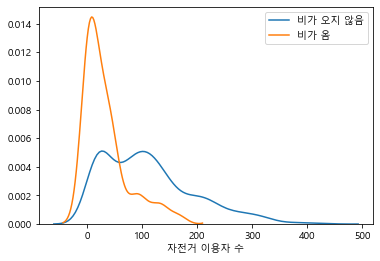

In [5]:
sns.kdeplot(train.loc[train['precipitation']==0,'count'] , label = '비가 오지 않음')
sns.kdeplot(train.loc[train['precipitation']==1,'count'] , label = '비가 옴')
plt.xlabel('자전거 이용자 수')
plt.show()

>- 비가 오는 날이면 이용자수가 확실히 적다는 것을 볼 수 있다 .
>- 그리고 직관적으로 생각해도 당연히 가장 중요한 요소라고 판단

In [6]:
# 강수량 데이터는 0과 1 뿐이므로 cateogry 로 type 변환
train['precipitation'] = train['precipitation'].astype('category')
test['precipitation'] = test['precipitation'].astype('category')

#####  count와 변수별 상관관계 확인(어느것이 가장 영향을 많이 끼치는가 확인)
- 강수량은 category타입이므로 제외

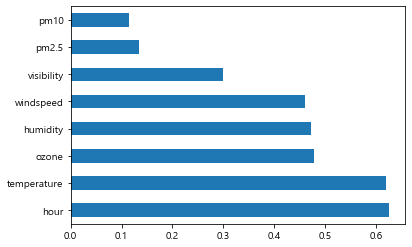

In [7]:
abs(train.corr()['count']).sort_values(ascending=False).drop(['id','count']).plot.barh()
plt.show()

>- hour , temperatur가 이용자 수와 상관관계가 높음을 확인할 수 있다.

### 전처리 과정보다 결측치 채우는 것에 더 초점을 둠

In [8]:
null_df = pd.DataFrame({'train__null' : train.isnull().sum().drop(['id','count']),
                        'test_null' : test.isnull().sum().drop('id')})

null_df

,train__null,test_null
hour,0,0
temperature,2,1
precipitation,2,1
windspeed,9,1
humidity,2,1
visibility,2,1
ozone,76,35
pm10,90,37
pm2.5,117,36


>- 결측치의 개수가 상당히 많은것을 볼 수 있음
>- 그래서 결측치를 채우는 것에 더 신경을 씀

# temperature 결측치 처리 

In [9]:
# train데이터에는 2개의 행이 모든 열이 NaN 임. 이 두개 행 DROP시킴.

train.drop(train[train['temperature'].isna()].index, inplace = True)
train.isna().sum()

id                 0
hour               0
temperature        0
precipitation      0
windspeed          7
humidity           0
visibility         0
ozone             74
pm10              88
pm2.5            115
count              0
dtype: int64

In [10]:
test[test['temperature'].isna()] #653.index

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5
653,1943,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
test.loc[test[test['temperature'].isna()].index , 'precipitation'] = 0  
#test.loc[ 653  , 'precipitation'] = 0   과 같다 . 


#위의 모든 열이 NaN인 행 한개를 강수량은 0으로 설정시켜둠 (대부분의 강수량이 0이므로 . )
#그리고 밑에서 강수량 == 0 , hour == 19인것을 이용해 그에 맞는  평균값을 넣어줌

In [12]:
one_null_index = ['temperature', 'humidity', 'visibility'] # 나머지 열들은 결측치 수 많아서 아래에서 같이 채워줄 예정임

for i in one_null_index:
    test.loc[test[test['visibility'].isna()].index , i] = test[(test['hour']==19) & (test['precipitation']==0)].mean()[i]
   #test.loc[ 653 , i] = test[(test['hour']==19) & (test['precipitation']==0)].mean()[i] 과 같다 . 


test.isna().sum()

id                0
hour              0
temperature       0
precipitation     0
windspeed         1
humidity          0
visibility        0
ozone            35
pm10             37
pm2.5            36
dtype: int64

# append / all_data  (데이터가 적어서 , 더 정확한 평균을 구하기 위해 합침) 

In [13]:
n_train = train.shape[0]  #n_train = 1457  
# 나중에 all_data를 다시 쪼개줄때 필요해서 저장해둔 변수


all_data = train.append(test, ignore_index=True)
all_data

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0
...,...,...,...,...,...,...,...,...,...,...,...
2167,2148,1,24.6,0.0,2.4,60.0,1745.0,NaN,NaN,NaN,NaN
2168,2149,1,18.1,0.0,1.0,55.0,2000.0,NaN,NaN,NaN,NaN
2169,2165,9,23.3,0.0,2.3,66.0,1789.0,0.020,17.0,15.0,NaN
2170,2166,16,27.0,0.0,1.6,46.0,1956.0,0.032,40.0,26.0,NaN


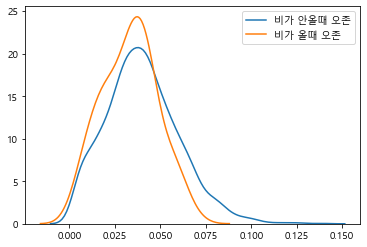

In [14]:
sns.kdeplot(all_data[all_data['precipitation']==0]['ozone'] , label = '비가 안올때 오존')
sns.kdeplot(all_data[all_data['precipitation']==1]['ozone'] , label = '비가 올때 오존')
plt.legend()
plt.show()

In [15]:
all_data.isna().sum()

id                 0
hour               0
temperature        0
precipitation      0
windspeed          8
humidity           0
visibility         0
ozone            109
pm10             125
pm2.5            151
count            715
dtype: int64

- 이제부터 해야될 것이 windspeed , ozone, pm10 pm2.5 순서대로 ,
- 강수가 0 이냐 1이냐로 구분시켜서 결측치를 채울것 .
- 강수를 나누는 이유는 , 강수에따라 오존값과 미세먼지값 , 풍속차이가 심하기 때문

# WindSpeed

In [16]:
# 특정 column과 다른 column의 상관관계를 한번에 볼 수 있는 그래프 만듬 (보기 쉽게 절대값 씌워줌)

def all_data_cor_plot(col_names, title = ' '):
    
    plt.subplot(1,2,1)
    abs(all_data[all_data['precipitation']==0].corr()[col_names][all_data.columns.difference(['id','count','precipitation',col_names])]).sort_values(ascending=False).plot.bar()
    plt.title('No Rain Corr')
    
    
    plt.subplot(1,2,2)
    abs(all_data[all_data['precipitation']==1].corr()[col_names][all_data.columns.difference(['id','count','precipitation',col_names])]).sort_values(ascending=False).plot.bar()
    plt.title('Rain Corr')
    
    plt.show()
    

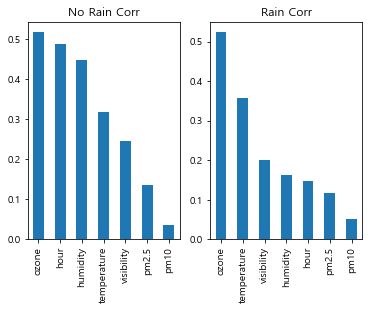

In [17]:
all_data_cor_plot('windspeed')

In [18]:
all_data[all_data['windspeed'].isna()]

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
18,33,13,22.600000,0.0,NaN,41.000000,987.000000,0.046,64.0,39.0,208.0
244,381,1,14.100000,0.0,NaN,55.000000,1992.000000,NaN,NaN,NaN,38.0
260,404,3,14.000000,0.0,NaN,50.000000,2000.000000,0.049,35.0,22.0,17.0
376,570,0,14.300000,0.0,NaN,49.000000,2000.000000,0.044,37.0,20.0,58.0
780,1196,20,16.500000,0.0,NaN,31.000000,2000.000000,0.058,39.0,18.0,181.0
1136,1717,12,21.400000,0.0,NaN,44.000000,1375.000000,0.044,61.0,37.0,116.0
1227,1855,2,14.000000,0.0,NaN,52.000000,2000.000000,0.044,37.0,20.0,20.0
2110,1943,19,26.548148,0.0,NaN,44.962963,1594.259259,NaN,NaN,NaN,NaN


>- 모든 windspeed가 NaN인 행의 강수는 0임 .. 그래서 상관관계 가장 높은 ozone에 대해 groupby시키고싶지만.. 
>-  ozone값이 groupby 시키기 애매해서 상관관계 그다음으로 높은 hour로 groupby시켜줌
>-  hour별로 windspeed가 확연히 다르기 때문이다 . 

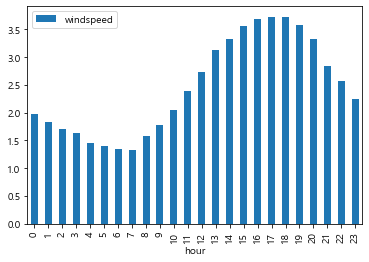

In [19]:
all_data.groupby(['hour']).mean()[['windspeed']].plot.bar()
plt.show()
# 여기서 hour 별로 windspeed가 확실히 다름을 볼 수 있다 . 

In [20]:
hour_windspeed = all_data.groupby(['hour','precipitation']).agg(['mean','count'])[['windspeed']]
hour_windspeed.head(10)
#count 넣어준것은 평균값 볼때 표본이 너무 적으면 값이 이상해질까봐..

windspeed      
                        mean count
hour precipitation                
0    0.0            1.953488    86
     1.0            2.800000     2
1    0.0            1.823529    85
     1.0            2.080000     5
2    0.0            1.705882    85
     1.0            1.540000     5
3    0.0            1.616092    87
     1.0            1.900000     3
4    0.0            1.423596    89
     1.0            2.800000     2

In [21]:
#이는 위 데이터프레임에서 , 해당 행의 hour 값에 맞춰서 windspeed의 평균값을 넣어줌.  
#참고로 'windspeed'가 결측치인 모든 행의 precipitation은 0이였음 . 

for i in all_data[all_data['windspeed'].isna()].index:
    all_data.loc[i, 'windspeed'] = hour_windspeed.loc[all_data.loc[i,'hour'],0][0]
    
all_data.isna().sum()

id                 0
hour               0
temperature        0
precipitation      0
windspeed          0
humidity           0
visibility         0
ozone            109
pm10             125
pm2.5            151
count            715
dtype: int64

# precipitation 결측치 / 한개만 존재 . 0으로 대체

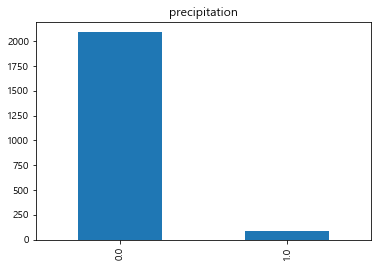

In [22]:
all_data['precipitation'].value_counts().plot.bar()
plt.title('precipitation')
plt.show()

all_data.loc[all_data['precipitation'].isna(), 'precipitation']=0

# Ozone 결측치 해결

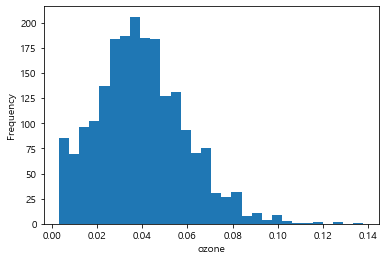

In [23]:
all_data['ozone'].plot.hist(bins = 30)
plt.xlabel('ozone')
plt.show()


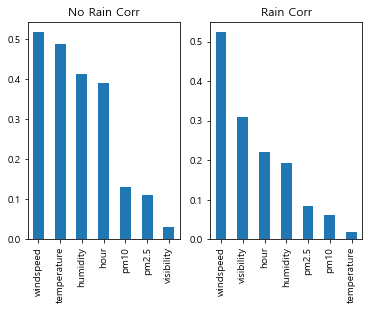

In [24]:
all_data_cor_plot('ozone')

In [25]:
all_data.head()

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [26]:
#precipitation == 1 인 ozone의 결측치만 넣어줌.
#그냥 precipitation == 1인 모든 데이터의 ozone평균값으로 대체시켜주는 코드임 . 
#나머지 결측치는 다 precipitation ==0일것. 

all_data.loc[(all_data['ozone'].isna()) & (all_data['precipitation']==1),'ozone'] = all_data.groupby('precipitation').mean()['ozone'][1]


In [27]:
all_data['wind_lev'] = pd.qcut(all_data['windspeed'].values, q =15, labels=range(15))

all_data['wind_lev'] = all_data['wind_lev'].astype(int)

all_data

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,wind_lev
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0,3
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0,3
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0,1
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0,8
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...
2167,2148,1,24.6,0.0,2.4,60.0,1745.0,NaN,NaN,NaN,NaN,7
2168,2149,1,18.1,0.0,1.0,55.0,2000.0,NaN,NaN,NaN,NaN,1
2169,2165,9,23.3,0.0,2.3,66.0,1789.0,0.020,17.0,15.0,NaN,7
2170,2166,16,27.0,0.0,1.6,46.0,1956.0,0.032,40.0,26.0,NaN,4


In [28]:
wind_rain_ozone = all_data.groupby(['wind_lev','precipitation']).mean()[['ozone']]
wind_rain_ozone

ozone
wind_lev precipitation          
0        0.0            0.024268
         1.0            0.019593
1        0.0            0.026164
         1.0            0.023741
2        0.0            0.028868
         1.0            0.027333
3        0.0            0.029347
         1.0            0.040857
4        0.0            0.032696
         1.0            0.039500
5        0.0            0.033925
         1.0            0.024143
6        0.0            0.036449
         1.0            0.037692
7        0.0            0.039220
         1.0            0.024026
8        0.0            0.041101
         1.0            0.039200
9        0.0            0.047145
         1.0            0.028667
10       0.0            0.047831
         1.0            0.045000
11       0.0            0.050312
         1.0            0.037250
12       0.0            0.053500
         1.0            0.038500
13       0.0            0.056393
         1.0            0.037077
14       0.0            0.055538
         1.0            0.051167

In [29]:
for i in all_data[all_data['ozone'].isna()].index:
    all_data.loc[i, 'ozone'] = wind_rain_ozone.loc[all_data.loc[i, 'wind_lev'],0]['ozone']
    
all_data.isna().sum()

id                 0
hour               0
temperature        0
precipitation      0
windspeed          0
humidity           0
visibility         0
ozone              0
pm10             125
pm2.5            151
count            715
wind_lev           0
dtype: int64

# pm10과 pm2.5 해결

# 1. 강수량이 1인 pm10과 pm2.5부터 해결.  / humidity와 상관성큼


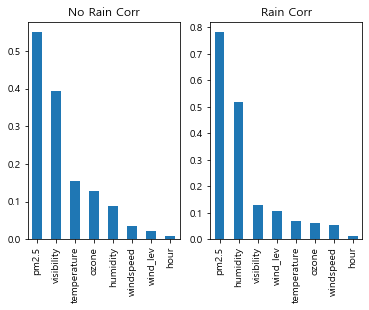

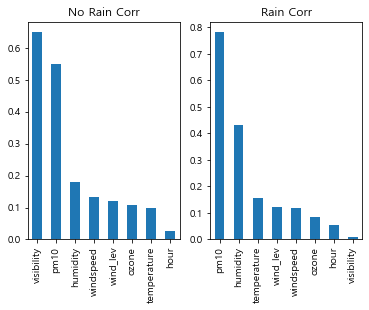

In [30]:
all_data_cor_plot('pm10')
all_data_cor_plot('pm2.5')


# 비가 오면 , humidity와 상관성이 크고 , 비가 안오면 visibility와 상관성이 큼.
### 비가 오는 경우부터 나누자   . 
### pm10 하고 , 그다음 바로 pm2.5 

In [31]:
all_data[(all_data['precipitation'] == 1) & (all_data['pm10'].isna())]
#비가 오고 , pm10이 결측값인 데이터

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,wind_lev
169,255,16,11.6,1.0,4.3,92.0,320.0,0.041000,NaN,NaN,36.0,13
222,346,1,12.4,1.0,2.4,99.0,232.0,0.033154,NaN,NaN,6.0,7
344,528,15,12.7,1.0,4.8,88.0,293.0,0.044000,NaN,NaN,8.0,14
507,782,1,11.3,1.0,4.3,88.0,295.0,0.033154,NaN,NaN,24.0,13
796,1214,1,17.8,1.0,1.0,91.0,323.0,0.033154,NaN,NaN,41.0,1
1497,115,1,21.5,1.0,0.5,90.0,347.0,0.033154,NaN,NaN,NaN,0
1559,297,1,15.1,1.0,2.2,98.0,224.0,0.033154,NaN,NaN,NaN,6


In [32]:
#비가 오면 pm데이터들은 humidity와 상관성이 높으므로 , humidity를 기준으로 값을 채워주고싶음 . groupby해야하는데
#값이 이산형이므로 , groupby시켜줄수있게 범주형으로 변환시켜줌 . 
all_data['humidity_lev'] = round(all_data['humidity'],-1)/10
all_data

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,wind_lev,humidity_lev
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027000,76.0,33.0,49.0,3,9.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042000,73.0,40.0,159.0,3,5.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033000,32.0,19.0,26.0,1,8.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040000,75.0,64.0,57.0,8,5.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057000,27.0,11.0,431.0,14,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,2148,1,24.6,0.0,2.4,60.0,1745.0,0.039220,NaN,NaN,NaN,7,6.0
2168,2149,1,18.1,0.0,1.0,55.0,2000.0,0.026164,NaN,NaN,NaN,1,6.0
2169,2165,9,23.3,0.0,2.3,66.0,1789.0,0.020000,17.0,15.0,NaN,7,7.0
2170,2166,16,27.0,0.0,1.6,46.0,1956.0,0.032000,40.0,26.0,NaN,4,5.0


In [33]:
humidity_pm10_pm25 = all_data.groupby('humidity_lev').mean()[['pm10', 'pm2.5']]
humidity_pm10_pm25

,pm10,pm2.5
humidity_lev,,
1.0,32.913043,12.826087
2.0,59.784722,21.909722
3.0,49.370833,26.692946
4.0,55.363636,28.368421
5.0,51.632399,29.165109
6.0,49.528481,30.401274
7.0,50.161435,30.774775
8.0,46.257246,30.428571
9.0,43.489362,31.321839


In [34]:
#위 데이터프레임에서 , 비가 온 날 pm2.5와 pm10의 결측치를 채워주는 과정 . 
# precipitation가 결측치인 행은 humidity_lev에 따라 그 결측치를 채워주는 과정임.

for i in all_data[(all_data['precipitation'] == 1) & (all_data['pm10'].isna() )].index:
    all_data.loc[i,'pm10'] = humidity_pm10_pm25.loc[ all_data.loc[i,'humidity_lev'] , 'pm10']
    
for i in all_data[(all_data['precipitation'] == 1) & (all_data['pm2.5'].isna() )].index:
    all_data.loc[i,'pm2.5'] = humidity_pm10_pm25.loc[ all_data.loc[i,'humidity_lev'] , 'pm2.5']


# 2. 강수량이 0인 pm10과 pm2.5 해결할것 / visibility와 상관성 큼

In [35]:
#visibility로 groupby시켜주기 위해 visibility_lev라는 새로운 변수 생성

all_data.loc[all_data['visibility']!=2000,'visibility_lev'] = pd.qcut(all_data[all_data['visibility']!=2000]['visibility'].values, q =20 , labels=range(20))

all_data['visibility_lev'] = all_data['visibility_lev'].fillna(20)
all_data['visibility_lev'] = all_data['visibility_lev'].astype('category')

all_data

,id,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,wind_lev,humidity_lev,visibility_lev
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027000,76.0,33.0,49.0,3,9.0,3
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042000,73.0,40.0,159.0,3,5.0,7
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033000,32.0,19.0,26.0,1,8.0,12
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040000,75.0,64.0,57.0,8,5.0,7
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057000,27.0,11.0,431.0,14,1.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,2148,1,24.6,0.0,2.4,60.0,1745.0,0.039220,NaN,NaN,NaN,7,6.0,15
2168,2149,1,18.1,0.0,1.0,55.0,2000.0,0.026164,NaN,NaN,NaN,1,6.0,20
2169,2165,9,23.3,0.0,2.3,66.0,1789.0,0.020000,17.0,15.0,NaN,7,7.0,15
2170,2166,16,27.0,0.0,1.6,46.0,1956.0,0.032000,40.0,26.0,NaN,4,5.0,18


In [36]:
all_data.groupby('visibility_lev').mean()[['pm10', 'pm2.5']]

,pm10,pm2.5
visibility_lev,,
0,54.106734,40.332268
1,49.868351,36.191866
2,68.710526,45.216216
3,64.000000,39.506494
4,66.013158,38.191781
5,59.294872,37.833333
6,64.545455,40.092105
7,66.986486,38.337838
8,68.333333,32.500000


In [37]:
humidity_pm10_pm25 = all_data.groupby('visibility_lev').mean()[['pm10', 'pm2.5']]
humidity_pm10_pm25.T
#보기 편하게 역행렬시킨것. 

visibility_lev,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
pm10,54.106734,49.868351,68.710526,64.000000,66.013158,59.294872,64.545455,66.986486,68.333333,61.525000,...,56.133333,53.797468,51.8125,50.166667,48.906667,49.040541,46.400000,43.487179,40.493506,33.218254
pm2.5,40.332268,36.191866,45.216216,39.506494,38.191781,37.833333,40.092105,38.337838,32.500000,31.448718,...,29.280000,28.974684,27.4375,27.358974,25.452055,25.662162,21.670886,23.038462,20.922078,17.930140


In [38]:
#위 데이터프레임으로 , precipitation==1인 데이터의 결측치는 아까 채웠고
#precipitation == 0인 데이터에서 pm 데이터의 결측치를 채우는 과정.
# pm 데이터가 결측치이면 , 그 행의 visibility_lev을 기준으로 위 데이터프레임을 통해 결측값 채움 . 

for i in all_data[(all_data['pm10'].isna()) & (all_data['precipitation']==0)].index:
    all_data.loc[i, 'pm10'] = humidity_pm10_pm25.loc[all_data.loc[i,'visibility_lev'] ,  'pm10']
    
for i in all_data[(all_data['pm2.5'].isna()) & (all_data['precipitation']==0)].index:
    all_data.loc[i, 'pm2.5'] = humidity_pm10_pm25.loc[all_data.loc[i,'visibility_lev'] ,  'pm2.5']
    
all_data.isna().sum()

id                  0
hour                0
temperature         0
precipitation       0
windspeed           0
humidity            0
visibility          0
ozone               0
pm10                0
pm2.5               0
count             715
wind_lev            0
humidity_lev        0
visibility_lev      0
dtype: int64

In [39]:
all_data = all_data.drop(['id','visibility','wind_lev','humidity_lev'], axis = 1)
all_data

,hour,temperature,precipitation,windspeed,humidity,ozone,pm10,pm2.5,count,visibility_lev
0,20,16.3,1.0,1.5,89.0,0.027000,76.000000,33.000000,49.0,3
1,13,20.1,0.0,1.4,48.0,0.042000,73.000000,40.000000,159.0,7
2,6,13.9,0.0,0.7,79.0,0.033000,32.000000,19.000000,26.0,12
3,23,8.1,0.0,2.7,54.0,0.040000,75.000000,64.000000,57.0,7
4,18,29.5,0.0,4.8,7.0,0.057000,27.000000,11.000000,431.0,20
...,...,...,...,...,...,...,...,...,...,...
2167,1,24.6,0.0,2.4,60.0,0.039220,48.906667,25.452055,NaN,15
2168,1,18.1,0.0,1.0,55.0,0.026164,33.218254,17.930140,NaN,20
2169,9,23.3,0.0,2.3,66.0,0.020000,17.000000,15.000000,NaN,15
2170,16,27.0,0.0,1.6,46.0,0.032000,40.000000,26.000000,NaN,18


In [40]:
all_data = pd.get_dummies(all_data)
all_data

,hour,temperature,windspeed,humidity,ozone,pm10,pm2.5,count,precipitation_0.0,precipitation_1.0,...,visibility_lev_11,visibility_lev_12,visibility_lev_13,visibility_lev_14,visibility_lev_15,visibility_lev_16,visibility_lev_17,visibility_lev_18,visibility_lev_19,visibility_lev_20
0,20,16.3,1.5,89.0,0.027000,76.000000,33.000000,49.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,13,20.1,1.4,48.0,0.042000,73.000000,40.000000,159.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,6,13.9,0.7,79.0,0.033000,32.000000,19.000000,26.0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,23,8.1,2.7,54.0,0.040000,75.000000,64.000000,57.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,18,29.5,4.8,7.0,0.057000,27.000000,11.000000,431.0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,1,24.6,2.4,60.0,0.039220,48.906667,25.452055,NaN,1,0,...,0,0,0,0,1,0,0,0,0,0
2168,1,18.1,1.0,55.0,0.026164,33.218254,17.930140,NaN,1,0,...,0,0,0,0,0,0,0,0,0,1
2169,9,23.3,2.3,66.0,0.020000,17.000000,15.000000,NaN,1,0,...,0,0,0,0,1,0,0,0,0,0
2170,16,27.0,1.6,46.0,0.032000,40.000000,26.000000,NaN,1,0,...,0,0,0,0,0,0,0,1,0,0


In [41]:
all_data_label = all_data.pop('count')
all_data_label

0        49.0
1       159.0
2        26.0
3        57.0
4       431.0
        ...  
2167      NaN
2168      NaN
2169      NaN
2170      NaN
2171      NaN
Name: count, Length: 2172, dtype: float64

In [42]:
all_data_describe = all_data.describe().T
all_data_describe

,count,mean,std,min,25%,50%,75%,max
hour,2172.0,11.488950,6.920445,0.000,5.750,11.000000,17.000,23.000
temperature,2172.0,18.873779,5.766513,3.100,14.600,18.900000,23.000,33.800
windspeed,2172.0,2.449366,1.312416,0.000,1.400,2.300000,3.400,8.000
humidity,2172.0,53.686447,20.239448,7.000,38.000,52.000000,70.000,100.000
ozone,2172.0,0.039653,0.019527,0.003,0.027,0.038000,0.051,0.138
pm10,2172.0,50.419835,27.953088,9.000,33.000,45.000000,61.000,269.000
pm2.5,2172.0,28.559032,13.298966,7.000,19.000,25.662162,35.000,90.000
precipitation_0.0,2172.0,0.961786,0.191756,0.000,1.000,1.000000,1.000,1.000
precipitation_1.0,2172.0,0.038214,0.191756,0.000,0.000,0.000000,0.000,1.000
visibility_lev_0,2172.0,0.037753,0.190643,0.000,0.000,0.000000,0.000,1.000


In [43]:
all_data = (all_data - all_data_describe['mean']) / all_data_describe['std']
all_data

,hour,temperature,windspeed,humidity,ozone,pm10,pm2.5,precipitation_0.0,precipitation_1.0,visibility_lev_0,...,visibility_lev_11,visibility_lev_12,visibility_lev_13,visibility_lev_14,visibility_lev_15,visibility_lev_16,visibility_lev_17,visibility_lev_18,visibility_lev_19,visibility_lev_20
0,1.229841,-0.446332,-0.723373,1.744788,-0.647963,0.915111,0.333933,-5.015684,5.015684,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
1,0.218346,0.212645,-0.799568,-0.280959,0.120198,0.807788,0.860290,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
2,-0.793150,-0.862528,-1.332936,1.250704,-0.340699,-0.658955,-0.718780,0.199283,-0.199283,-0.198031,...,-0.198031,5.112530,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
3,1.663340,-1.868335,0.190972,0.015492,0.017776,0.879336,2.664942,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
4,0.940843,1.842746,1.791075,-2.306706,0.888359,-0.837826,-1.320331,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,1.746664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,-1.515647,0.993013,-0.037615,0.311943,-0.022193,-0.054132,-0.233625,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,5.047383,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
2168,-1.515647,-0.134185,-1.104350,0.064901,-0.690800,-0.615373,-0.799227,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,1.746664
2169,-0.359652,0.767573,-0.113810,0.608394,-1.006438,-1.195569,-1.019555,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,5.047383,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
2170,0.651844,1.409209,-0.647178,-0.379776,-0.391909,-0.372762,-0.192423,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,5.047383,-0.198031,-0.572257


# 구해놓은 all_data를 다시 쪼개놓기. 

In [44]:
train_df = all_data[:n_train]
test_df = all_data[n_train:]
test_df.shape

(715, 30)

In [45]:
train_df.head()

,hour,temperature,windspeed,humidity,ozone,pm10,pm2.5,precipitation_0.0,precipitation_1.0,visibility_lev_0,...,visibility_lev_11,visibility_lev_12,visibility_lev_13,visibility_lev_14,visibility_lev_15,visibility_lev_16,visibility_lev_17,visibility_lev_18,visibility_lev_19,visibility_lev_20
0,1.229841,-0.446332,-0.723373,1.744788,-0.647963,0.915111,0.333933,-5.015684,5.015684,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
1,0.218346,0.212645,-0.799568,-0.280959,0.120198,0.807788,0.860290,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
2,-0.793150,-0.862528,-1.332936,1.250704,-0.340699,-0.658955,-0.718780,0.199283,-0.199283,-0.198031,...,-0.198031,5.112530,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
3,1.663340,-1.868335,0.190972,0.015492,0.017776,0.879336,2.664942,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
4,0.940843,1.842746,1.791075,-2.306706,0.888359,-0.837826,-1.320331,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,1.746664


In [46]:
X = train_df
y = all_data_label[:n_train]

X.head()

,hour,temperature,windspeed,humidity,ozone,pm10,pm2.5,precipitation_0.0,precipitation_1.0,visibility_lev_0,...,visibility_lev_11,visibility_lev_12,visibility_lev_13,visibility_lev_14,visibility_lev_15,visibility_lev_16,visibility_lev_17,visibility_lev_18,visibility_lev_19,visibility_lev_20
0,1.229841,-0.446332,-0.723373,1.744788,-0.647963,0.915111,0.333933,-5.015684,5.015684,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
1,0.218346,0.212645,-0.799568,-0.280959,0.120198,0.807788,0.860290,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
2,-0.793150,-0.862528,-1.332936,1.250704,-0.340699,-0.658955,-0.718780,0.199283,-0.199283,-0.198031,...,-0.198031,5.112530,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
3,1.663340,-1.868335,0.190972,0.015492,0.017776,0.879336,2.664942,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,-0.572257
4,0.940843,1.842746,1.791075,-2.306706,0.888359,-0.837826,-1.320331,0.199283,-0.199283,-0.198031,...,-0.198031,-0.195508,-0.199283,-0.198031,-0.198031,-0.195508,-0.198031,-0.198031,-0.198031,1.746664


In [47]:
obj_X = test_df
# 예측을 위한 데이터임 . test 데이터라보면됨

# 머신러닝

In [48]:
import xgboost as xgb
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import validation_curve , GridSearchCV

cv = KFold(n_splits = 6)
scorer = make_scorer(mean_squared_error)

# xgboost사용하기로함 . 

별다른이유는없음  여러모델 다 써서 정확도 가장 높은것 선택하는것이 좋지만 ,
일단은 xgboost만 사용하기로

# HYPEROPT 써볼것

In [49]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np

TRAIN_X, TEST_X, TRAIN_Y, TEST_Y = train_test_split(X,y,
                                                   test_size=0.2)
# 학습용데이터와 학습후 채점용데이터를 80:20으로 나눈것임
    

def objective(space):
    
    TRAIN_X, TEST_X, TRAIN_Y, TEST_Y = train_test_split(X,y,
                                                   test_size=0.2)
  
    clf = xgb.XGBRegressor(n_estimators =2500,
                           colsample_bytree=space['colsample_bytree'],
                         learning_rate = space['learning_rate'],
                           max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'],
                            objective='reg:squarederror',
                            reg_alpha = space['reg_alpha']
                          )

    eval_set  = [( TRAIN_X, TRAIN_Y), ( TEST_X, TEST_Y)]

    clf.fit( TRAIN_X, TRAIN_Y,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(TEST_X)
    mse_scr = mean_squared_error(TEST_Y, pred)                                #채점기준은 Mean Squared Error
    print( "SCORE:", np.sqrt(mse_scr))  
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }
#########################SPACE 에서 모든변수들 다 GRID SEARCH처럼 써서 , 최적파라미터 찾는듯##################

space = {'max_depth': hp.quniform("max_depth", 4, 16, 1),                    # 4 ~ 16까지 1씩 증가
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),             # 1 ~ 10까지 1씩 증가
        'subsample': hp.uniform ('subsample', 0.7, 1),                       # 0.7 ~ 1 까지 아무숫자나뽑는듯
        'gamma' : hp.uniform ('gamma', 0,2),
        'colsample_bytree' : hp.uniform ('colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('reg_lambda', 0,1),
         'learning_rate' : hp.uniform('learning_rate', 0.06, 0.13),
         'reg_alpha' : hp.uniform('reg_alpha', 0,2),
}

##############################################################################################################
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print( best)

SCORE:                                                                                                                 
34.73317326680932                                                                                                      
SCORE:                                                                                                                 
37.37091009868783                                                                                                      
SCORE:                                                                                                                 
37.18129491475163                                                                                                      
SCORE:                                                                                                                 
30.11784726518583                                                                                                      
SCORE:                                  

SCORE:                                                                                                                 
35.56339532968929                                                                                                      
SCORE:                                                                                                                 
33.36301971621539                                                                                                      
SCORE:                                                                                                                 
38.44239049386262                                                                                                      
SCORE:                                                                                                                 
41.12919938806953                                                                                                      
SCORE:                                  

SCORE:                                                                                                                 
40.12927163050921                                                                                                      
SCORE:                                                                                                                 
38.009045981437396                                                                                                     
SCORE:                                                                                                                 
39.60553595395509                                                                                                      
SCORE:                                                                                                                 
38.41375096265386                                                                                                      
SCORE:                                  

In [51]:
#여기서 MAX_DEPTH 값은 자연수로 나와야 오류가 안떠서 , 자연수로 바꿔줌
best['max_depth'] = int(best['max_depth'] )
best

{'colsample_bytree': 0.9174826118746727,
 'gamma': 1.34734277604318,
 'learning_rate': 0.07729113549538215,
 'max_depth': 9,
 'min_child': 6.0,
 'reg_alpha': 1.857823183398566,
 'reg_lambda': 0.028623654376547458,
 'subsample': 0.7998343908712436}

In [53]:
XGB_best_model = xgb.XGBRegressor(**best , objective='reg:squarederror')
XGB_best_model.fit(TRAIN_X, TRAIN_Y)
pred = XGB_best_model.predict(obj_X)
pred

array([ 1.00565407e+02,  2.12236404e+02,  9.03919525e+01,  5.79341812e+01,
        8.95451279e+01,  1.71034714e+02,  1.75930756e+02,  2.65109314e+02,
        3.68949890e+01,  1.66501404e+02,  3.00160339e+02,  2.49359665e+02,
        1.36576462e+02,  4.94489174e+01,  1.77872421e+02,  1.58395508e+02,
        2.23417454e+01,  1.69478745e+02,  3.72616180e+02,  1.61123306e+02,
        2.10987106e+02,  9.91483841e+01,  2.65478592e+01,  1.60623474e+02,
        1.41353058e+02,  1.14083855e+02,  2.77534256e+01,  1.43819916e+02,
        1.17953201e+02,  1.48817123e+02,  7.60695496e+01,  4.06591454e+01,
        6.88419571e+01,  1.49131332e+02,  2.84161865e+02,  2.96005535e+01,
        1.14430031e+02,  1.17095566e+02,  2.23962326e+02,  8.93236923e+01,
        4.45377960e+01,  1.37174515e+02,  1.79623245e+02,  1.01188995e+02,
        3.26486084e+02,  2.31564163e+02,  8.34558487e+01,  6.13669777e+01,
        2.99557438e+01,  8.79966354e+01,  2.06860687e+02,  9.10886841e+01,
        1.67359360e+02,  

In [60]:
print('예상 제출 점수 :', np.sqrt(np.mean(cross_val_score(XGB_best_model,TEST_X , TEST_Y , scoring=scorer , cv = cv))))
#print(np.sqrt(mean_squared_error(XGB_best_model.predict(TEST_X) ,TEST_Y )))

예상 제출 점수 : 42.46303526699289


# feature_importance (변수 중요도)

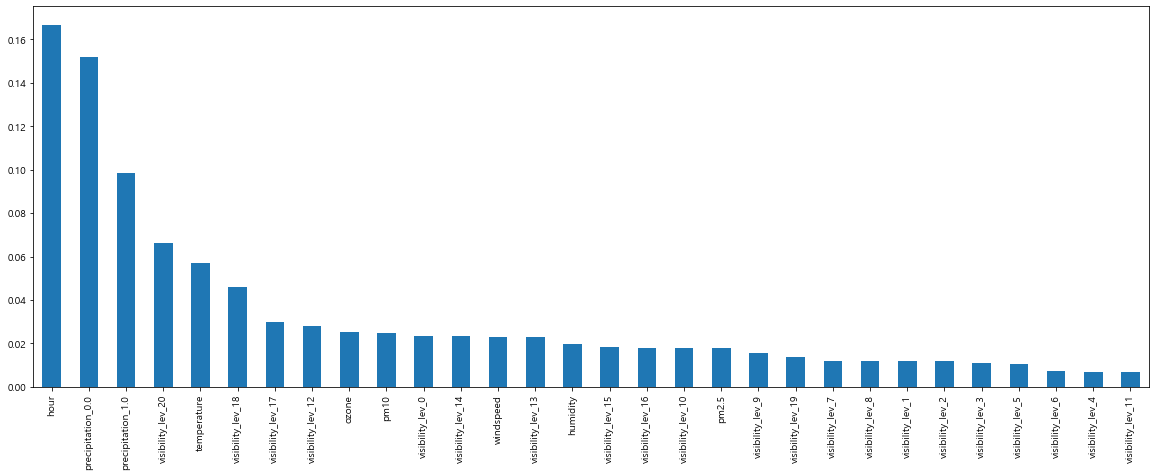

In [56]:
plt.figure(figsize=(20,7))
pd.Series(XGB_best_model.feature_importances_, index=TEST_X.columns).sort_values(ascending=False).plot.bar()
plt.show()

>- 모델로 예측 시 hour과 precipitation을 가장 중요한 변수로 생각하고 학습됐음을 볼 수 있다.